In [1]:
import numpy as np
import matplotlib.pyplot as plt

from joblib import Parallel, delayed, parallel_backend
from psiam_tied_dv_map_utils import psiam_tied_data_gen_wrapper_V_A_change
import pandas as pd

# Params

In [2]:
V_A = 1.1
theta_A = 1.8

rate_lambda = 0.14
T_0 = 0.66 * (1e-3)
theta_E = 40.5

t_A_aff = 0.03
t_E_aff = 0.05
t_motor = 0.03

Z_E = 0
L = 0.5

N_sim = int(100e3)
dt = 1e-4

step_size = 0.15
N_print = int(10e3)
N_params = 10

# ABL, ILD, stim and led times from data

In [3]:
og_df = pd.read_csv('../out_LED.csv')
df = og_df[ og_df['repeat_trial'].isin([0,2]) | og_df['repeat_trial'].isna() ]
session_type = 7    
df = df[ df['session_type'].isin([session_type]) ]
training_level = 16
df = df[ df['training_level'].isin([training_level]) ]

t_stim_and_led_tuple = [(row['intended_fix'], row['LED_onset_time']) for _, row in df.iterrows()]

ABL_arr = df['ABL'].unique()
ABL_arr.sort()

ILD_arr = df['ILD'].unique()
ILD_arr.sort()

# percentage of LED on trials
frac_of_led = df['LED_trial'].values.sum() / df['LED_trial'].values.size
print(f'frac_of_led: {frac_of_led}')

frac_of_led: 0.33939811074203746


# Simulate an example and check

In [4]:

# new_V_A = V_A + step_size
# N_print = int(5e3)

# with parallel_backend('threading', n_jobs=-1):
#     sim_results = Parallel()(
#         delayed(psiam_tied_data_gen_wrapper_V_A_change)(V_A, theta_A, ABL_arr, ILD_arr, rate_lambda, T_0, theta_E, Z_E, t_A_aff, t_E_aff, t_motor, L,t_stim_and_led_tuple, new_V_A, iter_num, N_print, dt)
#         for iter_num in range(N_sim)
#     )


                                    
# # checks
# # frac of LED trials
# num_led_on = [res['is_LED_trial'] for res in sim_results]

# sum_led = np.sum(num_led_on)

# print(f'frac of LED on trials: {sum_led/N_sim}')
# # led, stim distr
# led_times = [res['t_led'] for res in sim_results]
# stim_times = [ res['t_stim'] for res in sim_results]
# stim_minus_led = [res['t_stim'] - res['t_led'] for res in sim_results]

# plt.figure(figsize=(15,5))
# plt.subplot(1,3,1)
# plt.hist(led_times, bins=100)
# plt.xlabel('LED time')

# plt.subplot(1,3,2)
# plt.hist(stim_times, bins=100)
# plt.xlabel('stim time')

# plt.subplot(1,3,3)
# plt.hist(stim_minus_led, bins=100)
# plt.xlabel('stim - led time')


# simulate for different V_A

In [25]:
V_A_change_results_dict = {}
for i in range(N_params):
    new_V_A = V_A + step_size*i

    with parallel_backend('threading', n_jobs=512):
        sim_results = Parallel()(
            delayed(psiam_tied_data_gen_wrapper_V_A_change)(V_A, theta_A, ABL_arr, ILD_arr, rate_lambda, T_0, theta_E, Z_E, t_A_aff, t_E_aff, t_motor, L,t_stim_and_led_tuple, new_V_A, iter_num, N_print, dt)
            for iter_num in range(N_sim)
        )

    print(f'V_A: {V_A}, new_V_A: {new_V_A}')

    V_A_change_results_dict[i] = {'results': sim_results, 'new_V_A': new_V_A, 'V_A': V_A, }

os id: 36602, In iter_num: 0, ABL: 60, ILD: -1.0, t_stim: 0.417984771092751
os id: 36602, In iter_num: 10000, ABL: 40, ILD: -2.0, t_stim: 0.935315907005971
os id: 36602, In iter_num: 20000, ABL: 20, ILD: -8.0, t_stim: 0.530573331820709
os id: 36602, In iter_num: 30000, ABL: 60, ILD: 8.0, t_stim: 0.480776238146894
os id: 36602, In iter_num: 40000, ABL: 40, ILD: 8.0, t_stim: 0.30801576392286
os id: 36602, In iter_num: 50000, ABL: 20, ILD: -4.0, t_stim: 0.280609157258901
os id: 36602, In iter_num: 60000, ABL: 40, ILD: -4.0, t_stim: 0.529129435009271
os id: 36602, In iter_num: 70000, ABL: 20, ILD: 2.0, t_stim: 0.806282476747799


KeyboardInterrupt: 

In [ ]:
import pickle
# with open(f'V_A_change_results_dict_100K.pkl', 'wb') as f:
#     pickle.dump(V_A_change_results_dict, f)

with open(f'V_A_change_results_dict_100K.pkl', 'rb') as f:
    V_A_change_results_dict = pickle.load(f)

# check if higher new V_A has high aborts or not

 num of aborts for 1.10: 11042
 num of aborts for 1.25: 11500
 num of aborts for 1.40: 12004
 num of aborts for 1.55: 12482
 num of aborts for 1.70: 12888
 num of aborts for 1.85: 13668
 num of aborts for 2.00: 13869
 num of aborts for 2.15: 14605
 num of aborts for 2.30: 15032
 num of aborts for 2.45: 15424


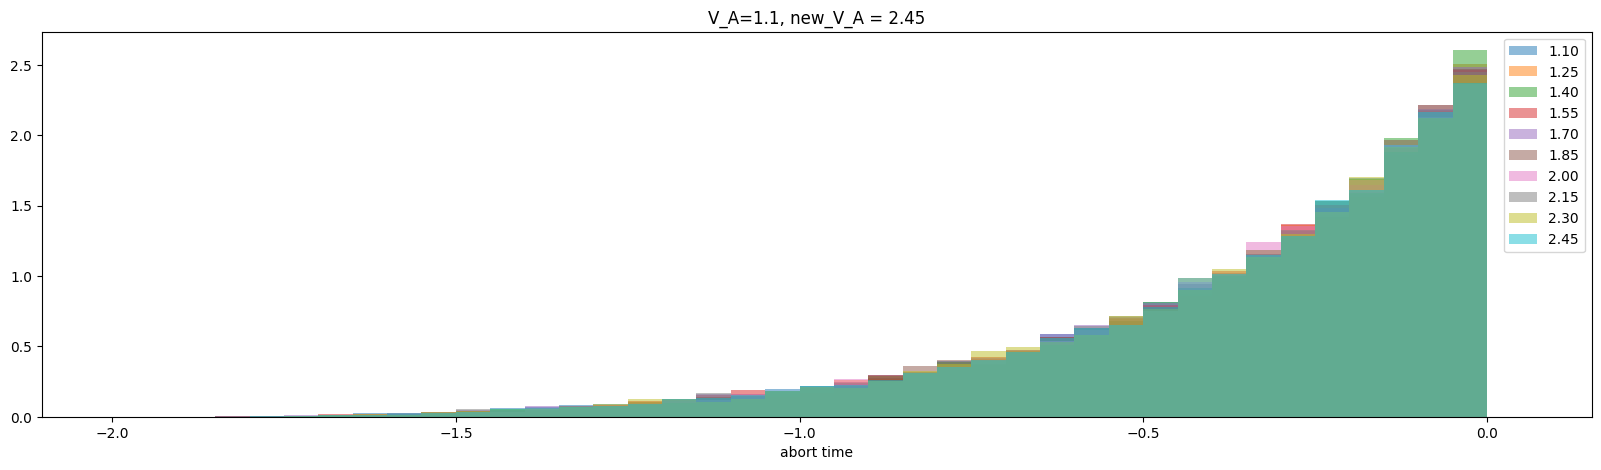

In [27]:
plt.figure(figsize=(20,5))
for i in range(N_params):
    each_V_A_results = V_A_change_results_dict[i]['results']
    # aborts distr
    each_V_A_new = V_A_change_results_dict[i]['new_V_A']
    all_V_A_old = V_A_change_results_dict[i]['V_A']

    each_V_A_aborts = [res['rt'] - res['t_stim'] for res in  each_V_A_results if res['rt'] < res['t_stim']]

    plt.hist(each_V_A_aborts, bins=np.arange(-2, 0.1, 0.05), density=True, alpha=0.5, label=f'{each_V_A_new:.2f}')
    plt.legend()
    plt.xlabel('abort time')
    
    

    plt.title( f'V_A={all_V_A_old}, new_V_A = {each_V_A_new:.2f}')
    print(f' num of aborts for {each_V_A_new:.2f}: {len(each_V_A_aborts)}')
    

# psychometrics for on and off

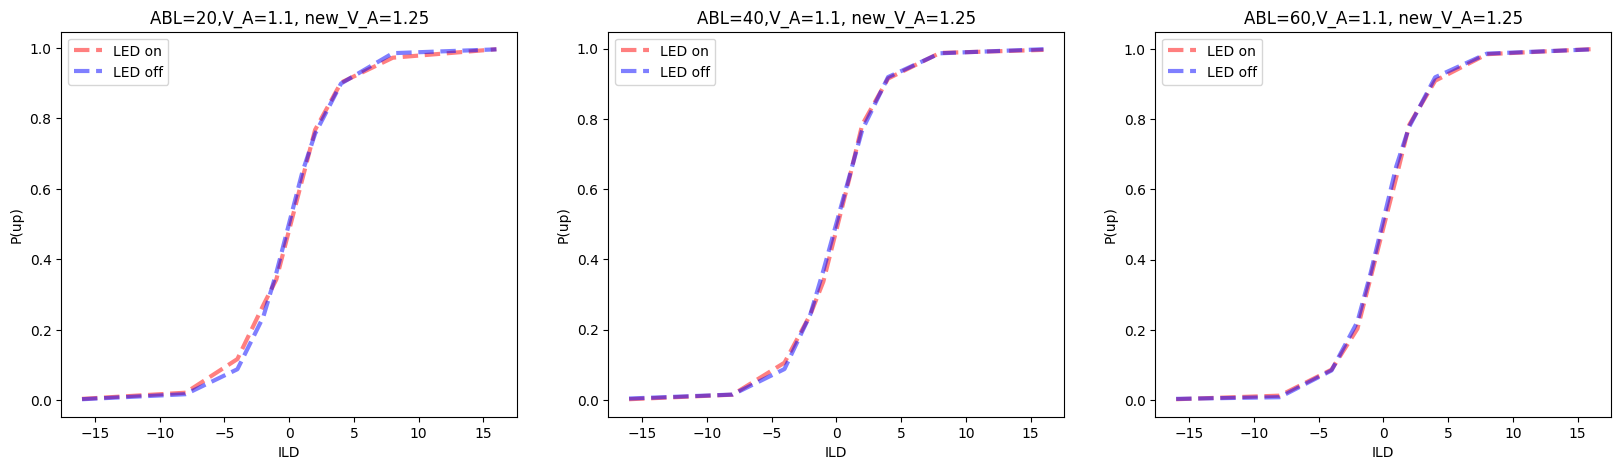

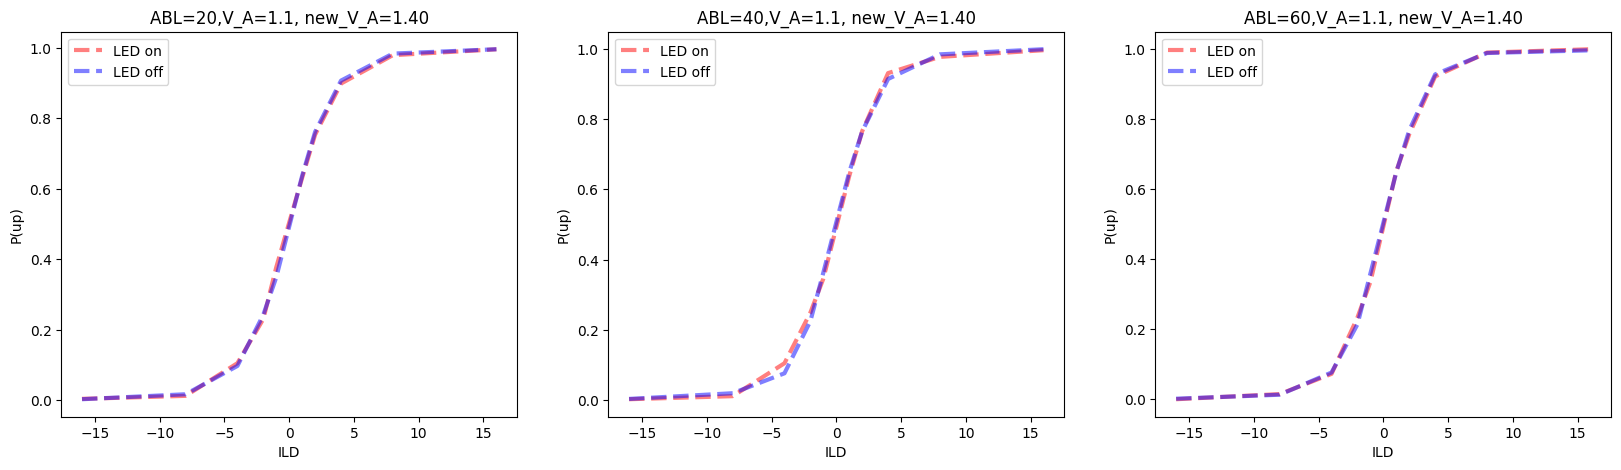

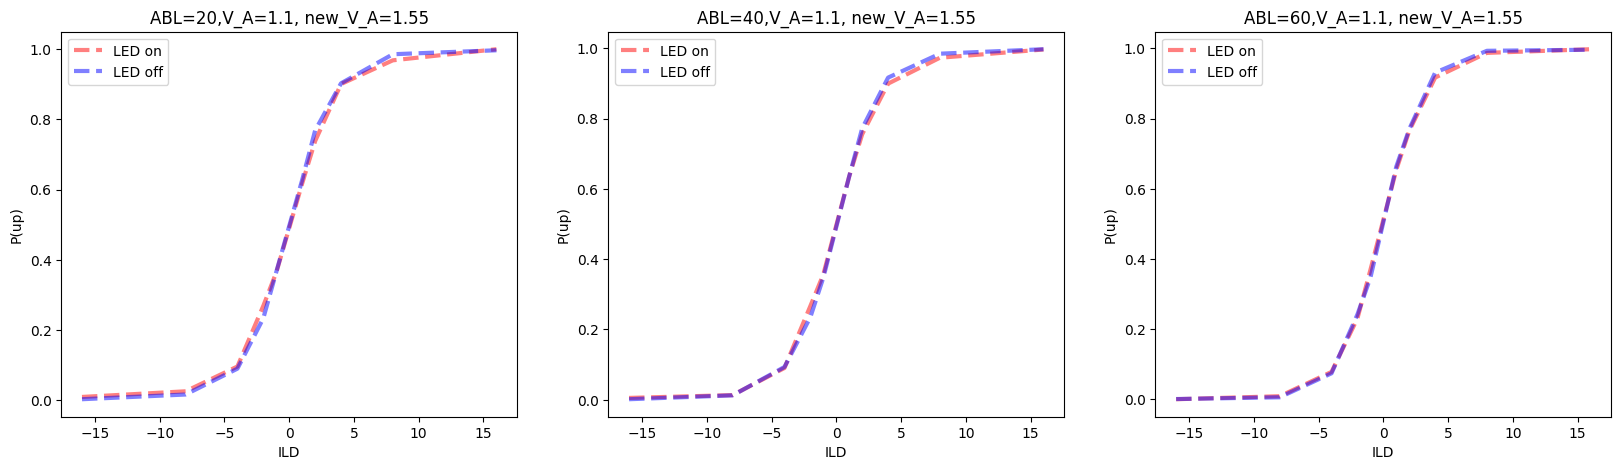

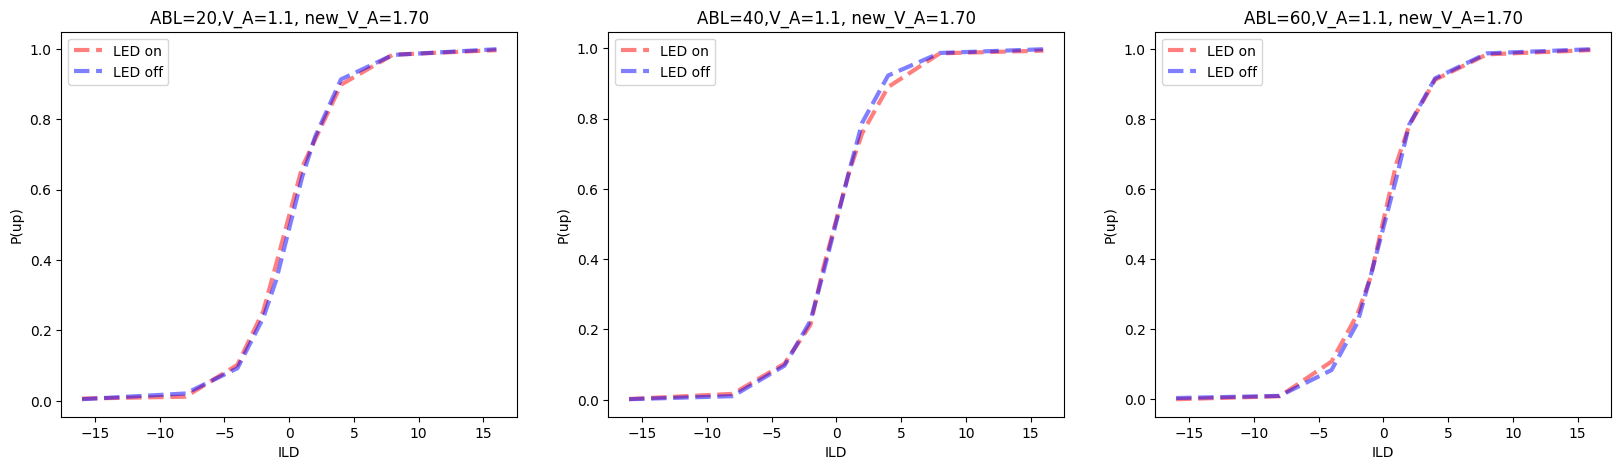

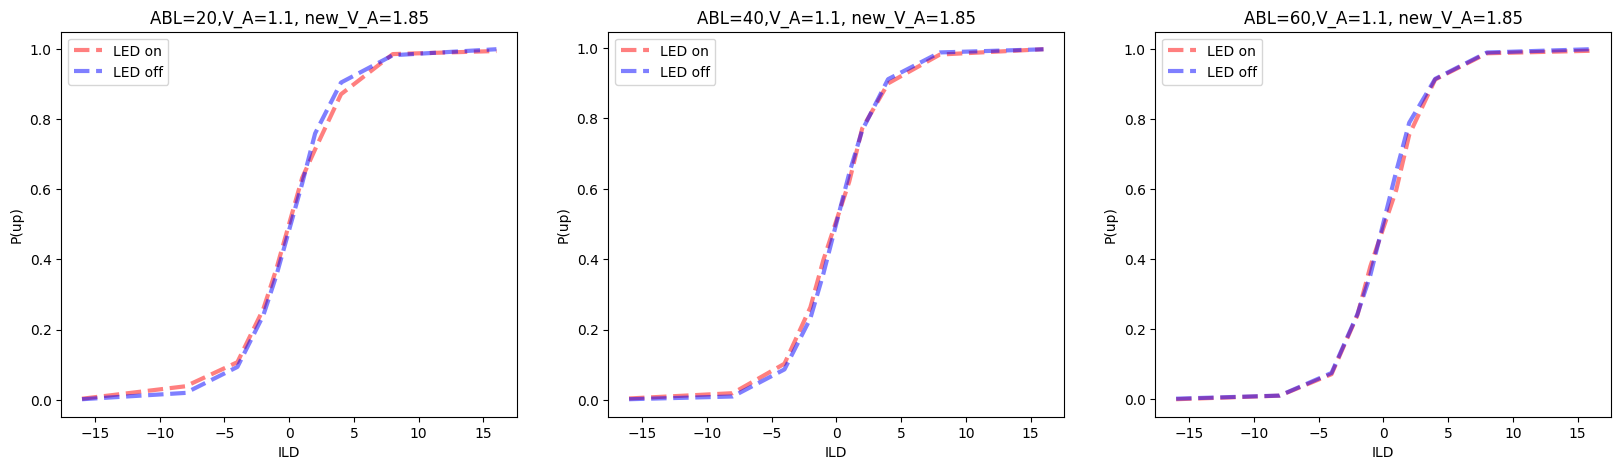

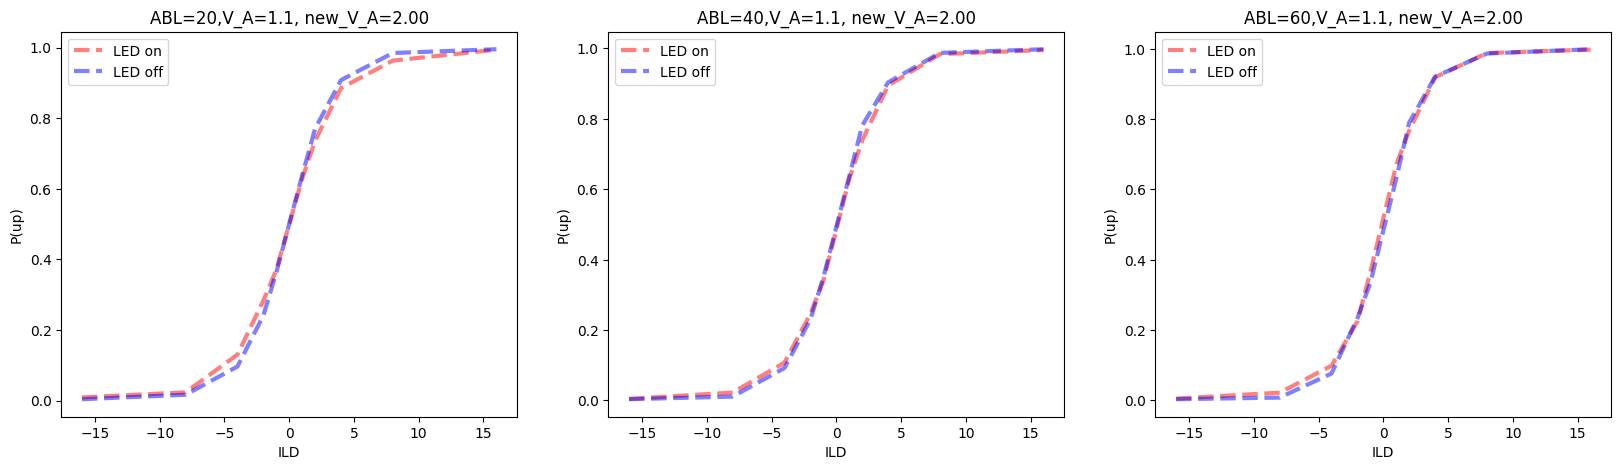

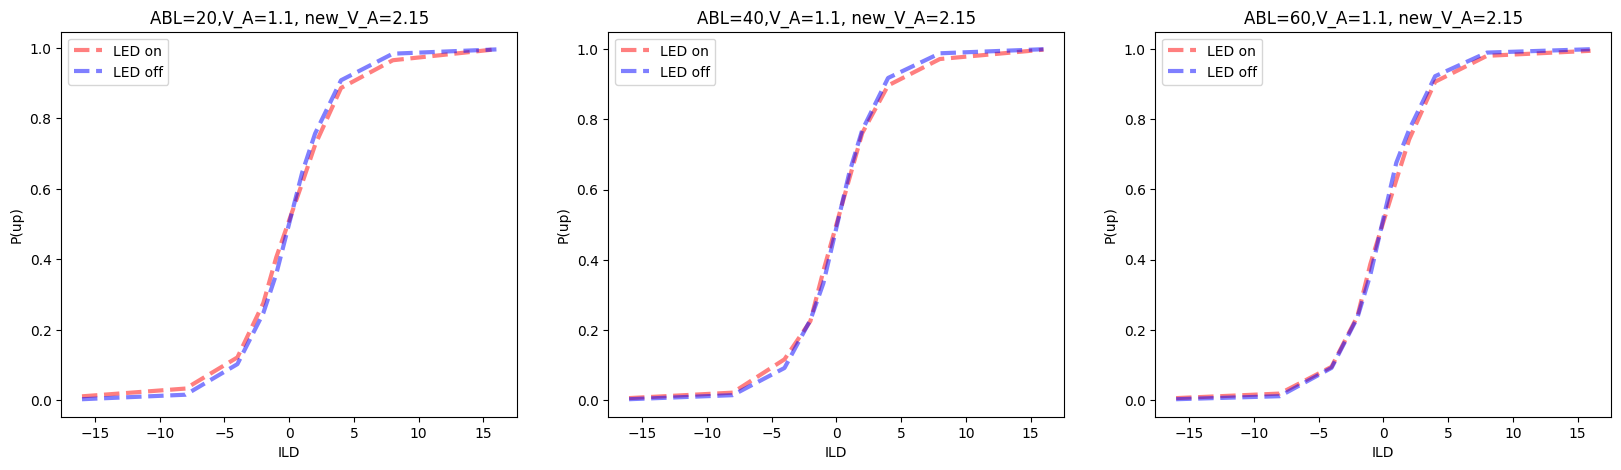

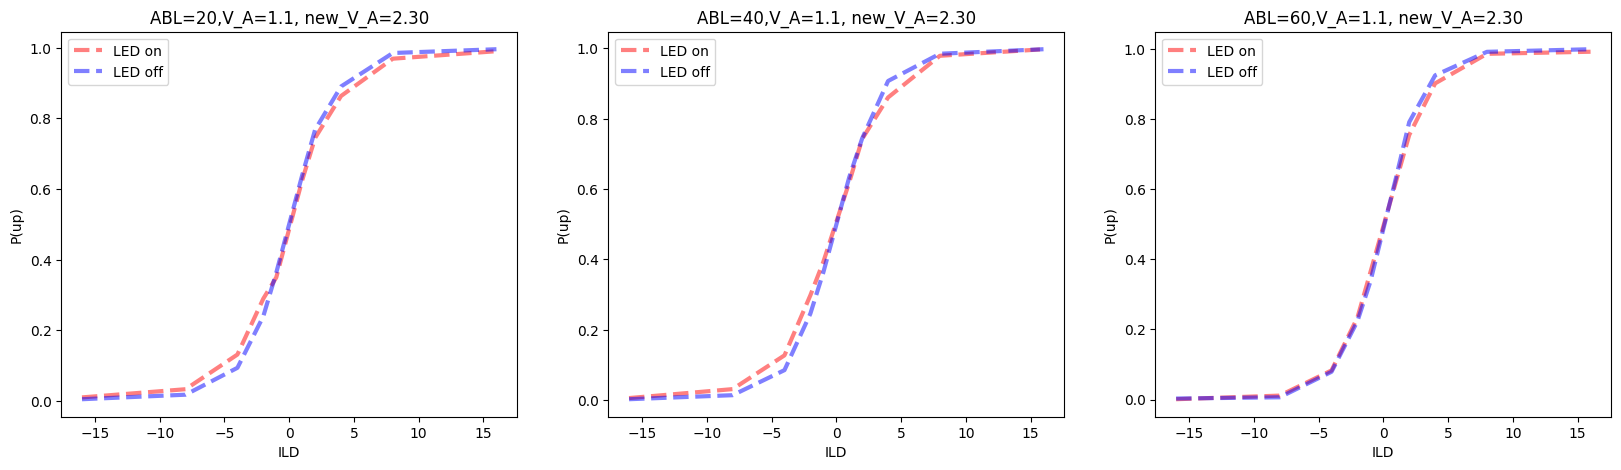

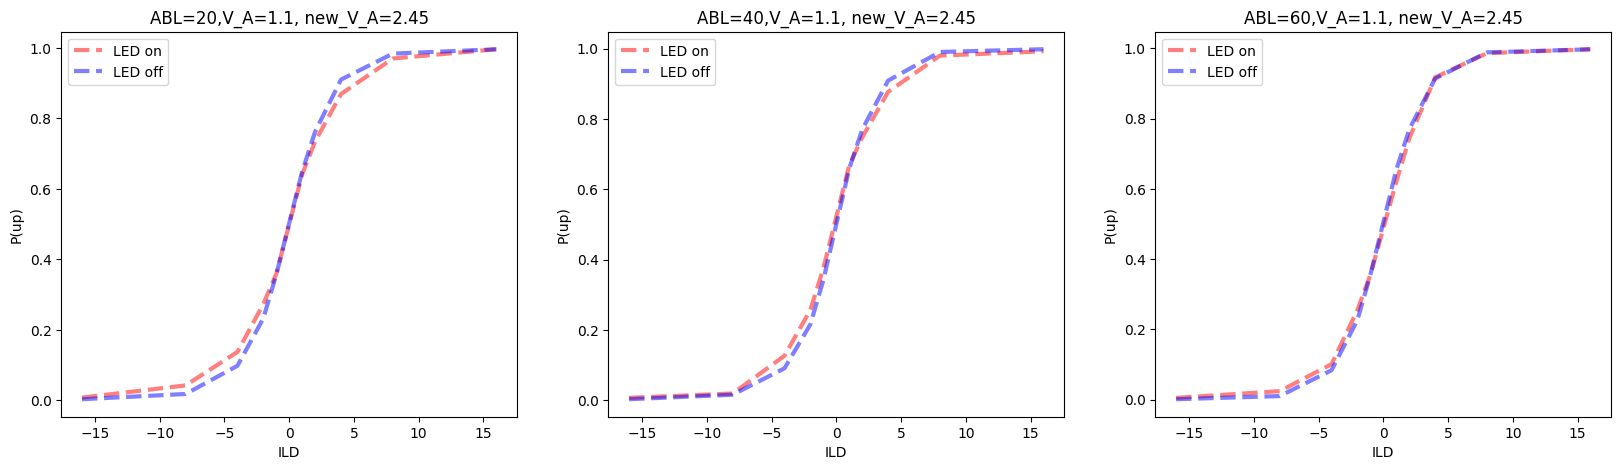

In [28]:
for i in range(1, N_params):
    # for each V_A
    each_V_A_results = V_A_change_results_dict[i]['results']
    base_V_A =  V_A_change_results_dict[i]['V_A']
    new_V_A = V_A_change_results_dict[i]['new_V_A']

    num_up_on = {}; num_trials_on = {}
    num_up_off = {}; num_trials_off = {}
    for ABL in ABL_arr:
        num_up_on[ABL] = np.zeros_like(ILD_arr)
        num_trials_on[ABL] = np.zeros_like(ILD_arr)

        num_up_off[ABL] = np.zeros_like(ILD_arr)
        num_trials_off[ABL] = np.zeros_like(ILD_arr)

    
    for res in each_V_A_results:
        ABL = res['ABL']
        ILD = res['ILD']
        is_LED_trial = res['is_LED_trial']
        if is_LED_trial:
            if res['rt'] > res['t_stim'] and res['rt'] > res['t_led']:
                num_trials_on[ABL][int(np.where(ILD_arr == ILD)[0][0])] += 1
                if res['choice'] == 1:
                    num_up_on[ABL][int(np.where(ILD_arr == ILD)[0][0])] += 1
        elif not is_LED_trial:
            if res['rt'] > res['t_stim'] and res['rt'] > res['t_led']:
                num_trials_off[ABL][int(np.where(ILD_arr == ILD)[0][0])] += 1
                if res['choice'] == 1:
                    num_up_off[ABL][int(np.where(ILD_arr == ILD)[0][0])] += 1

        

        

    plt.figure(figsize=(20,5))
    for a, ABL in enumerate(ABL_arr):
        plt.subplot(1, len(ABL_arr), a+1)
        plt.title(f'ABL={ABL},V_A={base_V_A}, new_V_A={new_V_A:.2f}')

        
        plt.plot(ILD_arr, num_up_on[ABL]/num_trials_on[ABL], label='LED on', linestyle='--', color='r', lw=3, alpha=0.5)
        plt.plot(ILD_arr, num_up_off[ABL]/num_trials_off[ABL], label='LED off', linestyle='--', color='b', lw=3, alpha=0.5)
        
        plt.legend()
        plt.xlabel('ILD'); plt.ylabel('P(up)');




# psychometric - designed

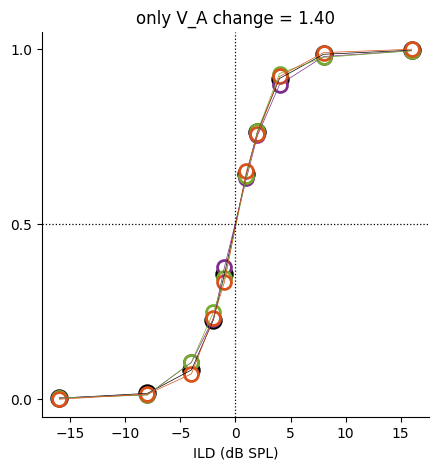

In [150]:
i = 2
# for each V_A
each_V_A_results = V_A_change_results_dict[i]['results']
base_V_A =  V_A_change_results_dict[i]['V_A']
new_V_A = V_A_change_results_dict[i]['new_V_A']

num_up_on = {}; num_trials_on = {}
num_up_off = {}; num_trials_off = {}
for ABL in ABL_arr:
    num_up_on[ABL] = np.zeros_like(ILD_arr)
    num_trials_on[ABL] = np.zeros_like(ILD_arr)

    num_up_off[ABL] = np.zeros_like(ILD_arr)
    num_trials_off[ABL] = np.zeros_like(ILD_arr)


for res in each_V_A_results:
    ABL = res['ABL']
    ILD = res['ILD']
    is_LED_trial = res['is_LED_trial']
    if is_LED_trial:
        if res['rt'] > res['t_stim'] and res['rt'] > res['t_led']:
            num_trials_on[ABL][int(np.where(ILD_arr == ILD)[0][0])] += 1
            if res['choice'] == 1:
                num_up_on[ABL][int(np.where(ILD_arr == ILD)[0][0])] += 1
    elif not is_LED_trial:
        if res['rt'] > res['t_stim'] and res['rt'] > res['t_led']:
            num_trials_off[ABL][int(np.where(ILD_arr == ILD)[0][0])] += 1
            if res['choice'] == 1:
                num_up_off[ABL][int(np.where(ILD_arr == ILD)[0][0])] += 1

    


# average all LED off
led_off_psycho = np.zeros((len(ABL_arr), len(ILD_arr)))
for a, ABL in enumerate(ABL_arr):
    led_off_psycho[a] = num_up_off[ABL]/num_trials_off[ABL]
  

# take average of led_off_psycho across first dimension
led_off_psycho_avg = np.mean(led_off_psycho, axis=0)
plt.figure(figsize=(5,5))
# off
plt.scatter(ILD_arr, led_off_psycho_avg, color='k', marker='o', s=150)
plt.plot(ILD_arr, led_off_psycho_avg, color='k', lw=0.5)

# on
ABL_color_codes = {ABL_arr[0]: '#7D2E8C', ABL_arr[1]: '#75AB2E', ABL_arr[2]: '#D95219'}
for a,ABL in enumerate(ABL_arr):
    plt.scatter(ILD_arr, num_up_on[ABL]/num_trials_on[ABL], label=f'{ABL}', edgecolor=ABL_color_codes[ABL], marker='o', s=100, facecolors='white', lw=2)
    plt.plot(ILD_arr, num_up_on[ABL]/num_trials_on[ABL], color=ABL_color_codes[ABL], lw=0.5)

plt.axhline(0.5, color='k', linestyle='dotted', lw=0.9)
plt.axvline(0, color='k', linestyle='dotted',lw=0.9)
plt.yticks([0, 0.5, 1])
plt.xlabel('ILD (dB SPL)')
plt.title(f'only V_A change = {new_V_A:.2f}')

ax = plt.gca()  # Get the current axis
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()



# plot all led off
# for a,ABL in enumerate(ABL_arr):
#     plt.plot(ILD_arr, led_off_psycho[a], label='LED off', linestyle='--', color='b', lw=3, alpha=0.5)
# plt.figure(figsize=(20,5))
# for a, ABL in enumerate(ABL_arr):
#     plt.subplot(1, len(ABL_arr), a+1)
#     plt.title(f'ABL={ABL},V_A={base_V_A}, new_V_A={new_V_A:.2f}')

    
#     plt.plot(ILD_arr, num_up_on[ABL]/num_trials_on[ABL], label='LED on', linestyle='--', color='r', lw=3, alpha=0.5)
#     plt.plot(ILD_arr, num_up_off[ABL]/num_trials_off[ABL], label='LED off', linestyle='--', color='b', lw=3, alpha=0.5)
    
#     plt.legend()
#     plt.xlabel('ILD'); plt.ylabel('P(up)');




# RT distributions

In [29]:
base_V_A_data = V_A_change_results_dict[0]['results']

base_V_A_data_led_on = [res['rt'] - res['t_stim'] for res in base_V_A_data if res['is_LED_trial'] and res['rt'] > res['t_led']]
base_V_A_data_led_off = [res['rt'] - res['t_stim'] for res in base_V_A_data if not res['is_LED_trial'] and res['rt'] > res['t_led']]

# change V_A
new_V_A_idx = 1
new_V_A_value = V_A_change_results_dict[new_V_A_idx]['new_V_A']
new_V_A_data = V_A_change_results_dict[new_V_A_idx]['results']

new_V_A_data_led_on = [res['rt'] - res['t_stim'] for res in new_V_A_data if res['is_LED_trial'] and res['rt'] > res['t_led']]
new_V_A_data_led_off = [res['rt'] - res['t_stim'] for res in new_V_A_data if not res['is_LED_trial'] and res['rt'] > res['t_led'] ]


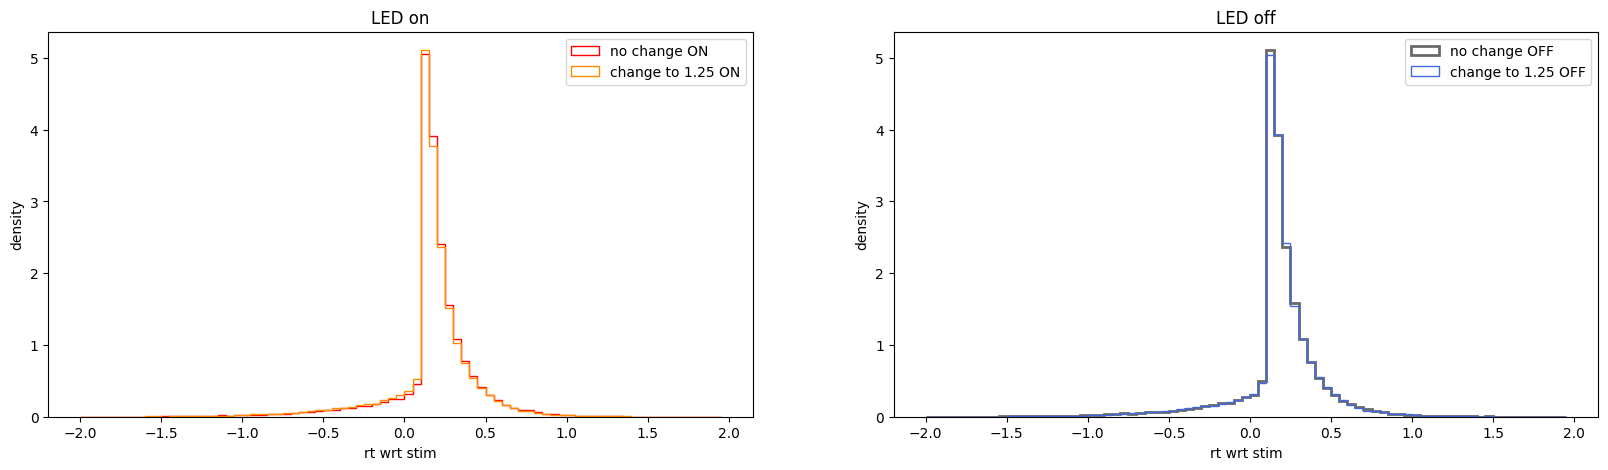

In [30]:
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.hist(base_V_A_data_led_on, bins=np.arange(-2, 2, 0.05), density=True, label='no change ON', color='r', histtype='step')
plt.hist(new_V_A_data_led_on, bins=np.arange(-2, 2, 0.05), density=True, label=f'change to {new_V_A_value:.2f} ON', color='darkorange', histtype='step')
plt.title('LED on')
plt.xlabel('rt wrt stim'); plt.ylabel('density')
plt.legend()

plt.subplot(1,2,2)
plt.hist(base_V_A_data_led_off, bins=np.arange(-2, 2, 0.05), density=True, label='no change OFF', color='dimgray', histtype='step', lw=2)
plt.hist(new_V_A_data_led_off, bins=np.arange(-2, 2, 0.05), density=True, label=f'change to {new_V_A_value:.2f} OFF', color='royalblue', histtype='step')
plt.title('LED off')
plt.xlabel('rt wrt stim'); plt.ylabel('density')
plt.legend();

# Percentiles

In [31]:
base_V_A_data = V_A_change_results_dict[0]['results']

base_V_A_data_led_on = [res['rt'] - res['t_stim'] for res in base_V_A_data if res['is_LED_trial'] and res['rt'] > res['t_led']]
base_V_A_data_led_off = [res['rt'] - res['t_stim'] for res in base_V_A_data if not res['is_LED_trial'] and res['rt'] > res['t_led']]

# change V_A
new_V_A_idx = 9
new_V_A_value = V_A_change_results_dict[new_V_A_idx]['new_V_A']
new_V_A_data = V_A_change_results_dict[new_V_A_idx]['results']

new_V_A_data_led_on = [res['rt'] - res['t_stim'] for res in new_V_A_data if res['is_LED_trial'] and res['rt'] > res['t_led']]
new_V_A_data_led_off = [res['rt'] - res['t_stim'] for res in new_V_A_data if not res['is_LED_trial'] and res['rt'] > res['t_led'] ]


In [32]:
base_on_abl_ild = {}
base_off_abl_ild = {}

new_on_abl_ild = {}
new_off_abl_ild = {}

for ABL in ABL_arr:
    for ILD in ILD_arr:
        base_on_abl_ild[(ABL, int(ILD))] = []
        base_off_abl_ild[(ABL, int(ILD))] = []

        new_on_abl_ild[(ABL, int(ILD))] = []
        new_off_abl_ild[(ABL, int(ILD))] = []

for res in base_V_A_data:
    ABL = res['ABL']
    ILD = res['ILD']
    is_LED_trial = res['is_LED_trial']
    if is_LED_trial:
        if res['rt'] > res['t_led']:
            base_on_abl_ild[ABL, int(ILD)].append(res['rt'] - res['t_stim'])
    elif not is_LED_trial:
        if res['rt'] > res['t_led']:
            base_off_abl_ild[ABL, int(ILD)].append(res['rt'] - res['t_stim'])


for res in new_V_A_data:
    ABL = res['ABL']
    ILD = res['ILD']
    is_LED_trial = res['is_LED_trial']
    if is_LED_trial:
        if res['rt'] > res['t_led']:
            new_on_abl_ild[ABL, int(ILD)].append(res['rt'] - res['t_stim'])
    elif not is_LED_trial:
        if res['rt'] > res['t_led']:
            new_off_abl_ild[ABL, int(ILD)].append(res['rt'] - res['t_stim'])

In [33]:
base_on_percentiles_dict = {}
base_off_percentiles_dict = {}

new_on_percentiles_dict = {}
new_off_percentiles_dict = {}

percentiles = [10, 30, 50, 70, 90]


for ABL in ABL_arr:
    base_on_percentiles_dict[ABL] = np.zeros((len(percentiles), len(ILD_arr)))
    base_off_percentiles_dict[ABL] = np.zeros((len(percentiles), len(ILD_arr)))

    new_on_percentiles_dict[ABL] = np.zeros((len(percentiles), len(ILD_arr)))
    new_off_percentiles_dict[ABL] = np.zeros((len(percentiles), len(ILD_arr)))


for ABL in ABL_arr:
    for ild_idx,ILD in enumerate(ILD_arr):
        for p, percentile in enumerate(percentiles):
            base_on_percentiles_dict[ABL][(p, ild_idx)] = np.percentile(base_on_abl_ild[ABL, int(ILD)], percentile)
            base_off_percentiles_dict[ABL][p, ild_idx] = np.percentile(base_off_abl_ild[ABL, int(ILD)], percentile)

            new_on_percentiles_dict[ABL][p, ild_idx] = np.percentile(new_on_abl_ild[ABL, int(ILD)], percentile)
            new_off_percentiles_dict[ABL][p, ild_idx] = np.percentile(new_off_abl_ild[ABL, int(ILD)], percentile)

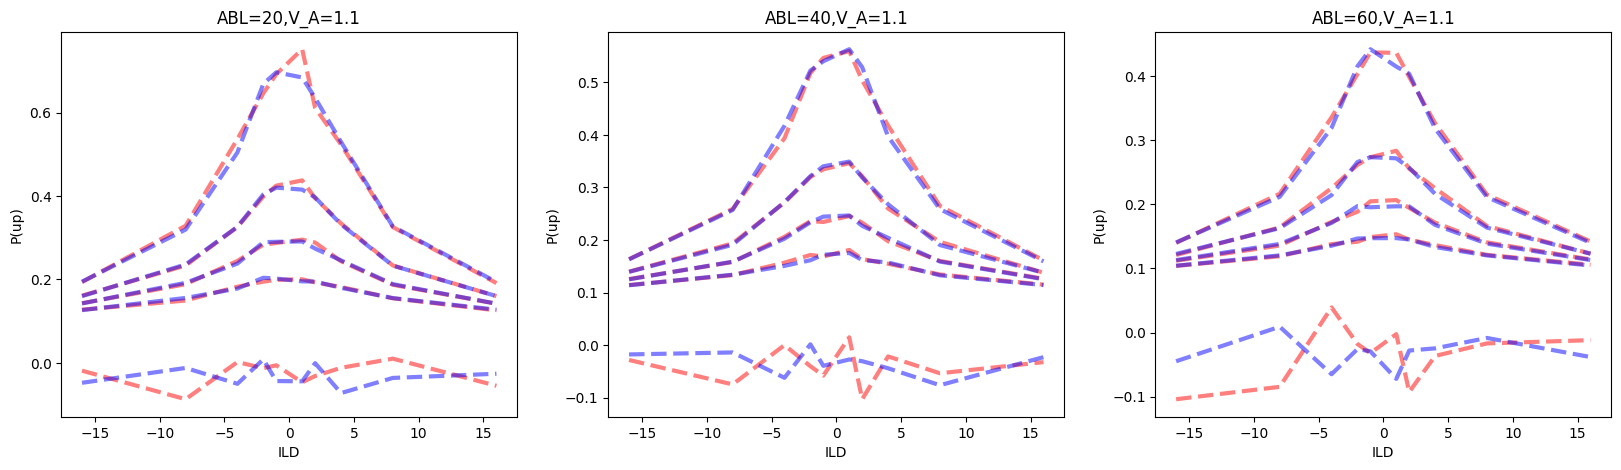

In [34]:
# plot
plt.figure(figsize=(20,5))
for a, ABL in enumerate(ABL_arr):
    plt.subplot(1, len(ABL_arr), a+1)
    plt.title(f'ABL={ABL},V_A={base_V_A}')
    for p, percentile in enumerate(percentiles):
        plt.plot(ILD_arr, base_on_percentiles_dict[ABL][p], label=f'base ON {percentile}', linestyle='--', color='r', lw=3, alpha=0.5)
        plt.plot(ILD_arr, base_off_percentiles_dict[ABL][p], label=f'base OFF {percentile}', linestyle='--', color='b', lw=3, alpha=0.5)



    plt.xlabel('ILD'); plt.ylabel('P(up)');

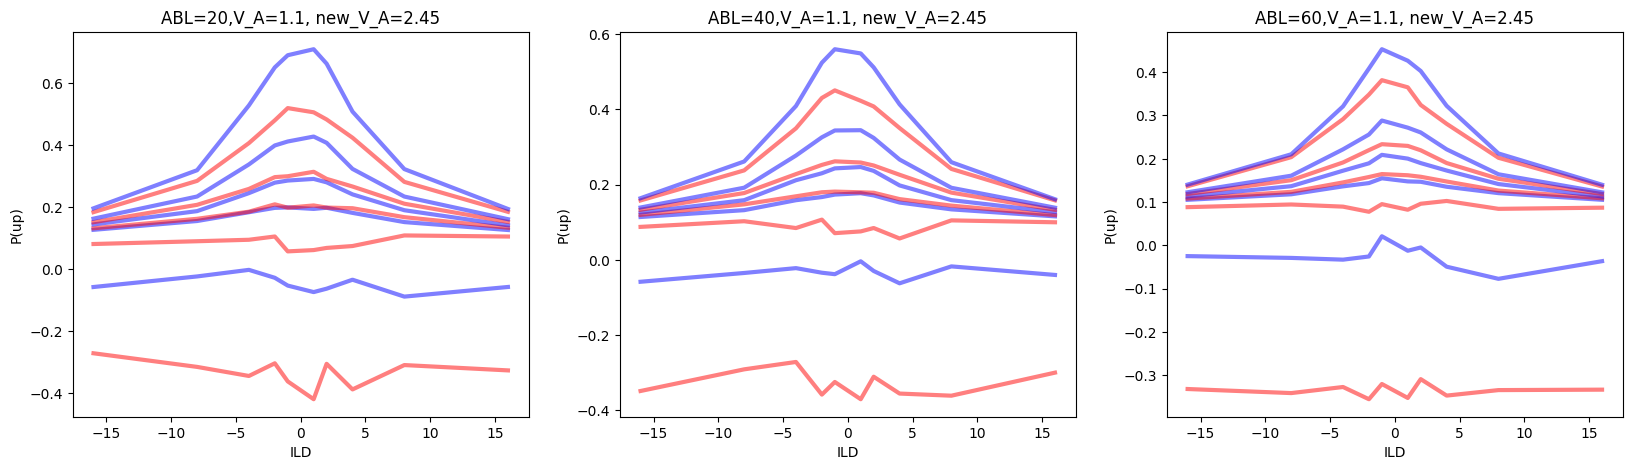

In [35]:


# plot
plt.figure(figsize=(20,5))
for a, ABL in enumerate(ABL_arr):
    plt.subplot(1, len(ABL_arr), a+1)
    plt.title(f'ABL={ABL},V_A={base_V_A}, new_V_A={new_V_A_value:.2f}')
    for p, percentile in enumerate(percentiles):
        plt.plot(ILD_arr, new_on_percentiles_dict[ABL][p], label=f'new ON {percentile}', linestyle='-', color='r', lw=3, alpha=0.5)
        plt.plot(ILD_arr, new_off_percentiles_dict[ABL][p], label=f'new OFF {percentile}', linestyle='-', color='b', lw=3, alpha=0.5)



    plt.xlabel('ILD'); plt.ylabel('P(up)');

# PSTH of rt

In [36]:
base_V_A_data = V_A_change_results_dict[0]['results']


# change V_A
new_V_A_idx = 9
new_V_A_value = V_A_change_results_dict[new_V_A_idx]['new_V_A']
new_V_A_data = V_A_change_results_dict[new_V_A_idx]['results']


t_min = -0.1; t_max = 5; t_bin = 0.05
t_pts = np.arange(t_min, t_max, t_bin)

base_on_wrt_led = np.zeros_like(t_pts)
base_off_wrt_led = np.zeros_like(t_pts)

new_on_wrt_led = np.zeros_like(t_pts)
new_off_wrt_led = np.zeros_like(t_pts)

# base
for res in base_V_A_data:
    if res['is_LED_trial']:
        if res['rt'] > res['t_led']:
            idx = int((res['rt'] - res['t_led'] - t_min) // t_bin)
            if idx >= 0 and idx < len(base_on_wrt_led):
                base_on_wrt_led[idx] += 1
            else:
                print(f'base on: {idx}')
    else:
        if res['rt'] > res['t_led']:
            idx = int((res['rt'] - res['t_led'] - t_min) // t_bin)
            if idx >= 0 and idx < len(base_off_wrt_led):
                base_off_wrt_led[idx] += 1
            else:
                print(f'base off: {idx}')


base_on_wrt_led_prob = base_on_wrt_led / (np.sum(base_on_wrt_led)*t_bin)
base_off_wrt_led_prob = base_off_wrt_led / (np.sum(base_off_wrt_led)*t_bin)


# new
for res in new_V_A_data:
    if res['is_LED_trial']:
        if res['rt'] > res['t_led']:
            idx = int((res['rt'] - res['t_led'] - t_min) // t_bin)
            if idx >= 0 and idx < len(new_on_wrt_led):
                new_on_wrt_led[idx] += 1
            else:
                print(f'new on: {idx}')
    else:
        if res['rt'] > res['t_led']:
            idx = int((res['rt'] - res['t_led'] - t_min) // t_bin)
            if idx >= 0 and idx < len(new_off_wrt_led):
                new_off_wrt_led[idx] += 1
            else:
                print(f'new off: {idx}')

new_on_wrt_led_prob = new_on_wrt_led / (np.sum(new_on_wrt_led)*t_bin)
new_off_wrt_led_prob = new_off_wrt_led / (np.sum(new_off_wrt_led)*t_bin)

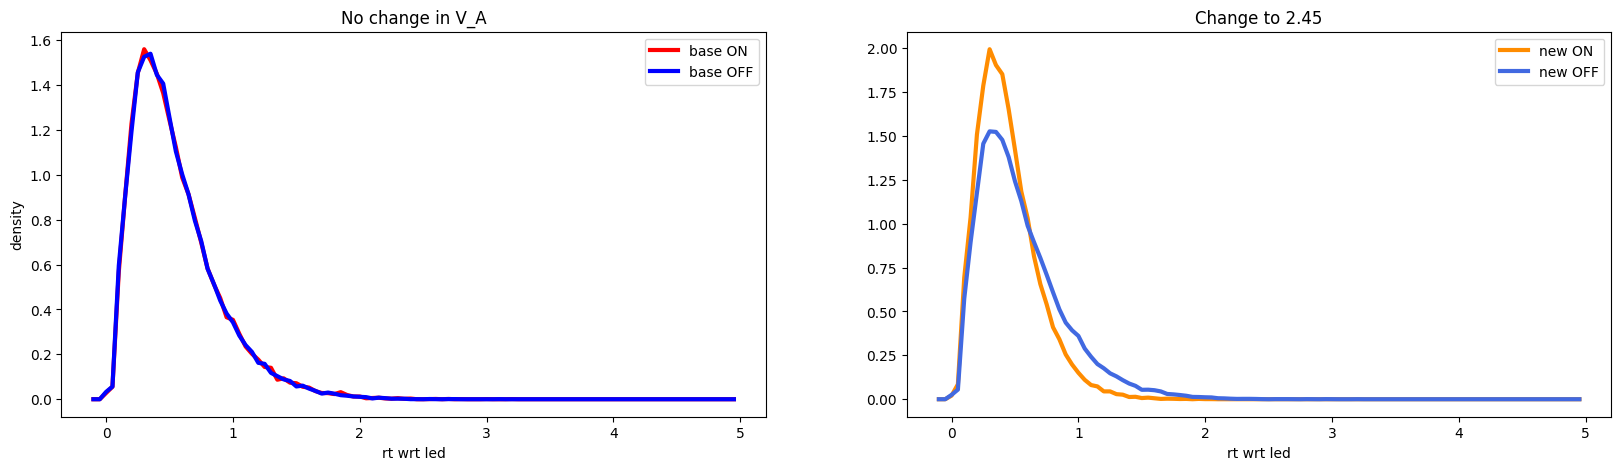

In [37]:
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.plot(t_pts, base_on_wrt_led_prob, label='base ON', color='r', lw=3)
plt.plot(t_pts, base_off_wrt_led_prob, label='base OFF', color='b', lw=3)
plt.title('No change in V_A')
plt.xlabel('rt wrt led')
plt.ylabel('density')
plt.legend()


plt.subplot(1,2,2)
plt.plot(t_pts, new_on_wrt_led_prob, label='new ON', color='darkorange', lw=3)
plt.plot(t_pts, new_off_wrt_led_prob, label='new OFF', color='royalblue', lw=3)
plt.title(f'Change to {new_V_A_value:.2f}')
plt.xlabel('rt wrt led')
plt.legend()


# psth of abort

In [38]:
base_V_A_data = V_A_change_results_dict[0]['results']


# change V_A
new_V_A_idx = 6
new_V_A_value = V_A_change_results_dict[new_V_A_idx]['new_V_A']
new_V_A_data = V_A_change_results_dict[new_V_A_idx]['results']


t_min = -0.1; t_max = 5; t_bin = 0.05
t_pts = np.arange(t_min, t_max, t_bin)

base_on_wrt_led = np.zeros_like(t_pts)
base_off_wrt_led = np.zeros_like(t_pts)

new_on_wrt_led = np.zeros_like(t_pts)
new_off_wrt_led = np.zeros_like(t_pts)

# base
for res in base_V_A_data:
    if res['is_LED_trial']:
        if res['rt'] > res['t_led'] and res['rt'] < res['t_stim']:
            idx = int((res['rt'] - res['t_led'] - t_min) // t_bin)
            if idx >= 0 and idx < len(base_on_wrt_led):
                base_on_wrt_led[idx] += 1
            else:
                print(f'base on: {idx}')
    else:
        if res['rt'] > res['t_led'] and res['rt'] < res['t_stim']:
            idx = int((res['rt'] - res['t_led'] - t_min) // t_bin)
            if idx >= 0 and idx < len(base_off_wrt_led):
                base_off_wrt_led[idx] += 1
            else:
                print(f'base off: {idx}')


base_on_wrt_led_prob = base_on_wrt_led / (np.sum(base_on_wrt_led)*t_bin)
base_off_wrt_led_prob = base_off_wrt_led / (np.sum(base_off_wrt_led)*t_bin)


# new
for res in new_V_A_data:
    if res['is_LED_trial']:
        if res['rt'] > res['t_led'] and res['rt'] < res['t_stim']:
            idx = int((res['rt'] - res['t_led'] - t_min) // t_bin)
            if idx >= 0 and idx < len(new_on_wrt_led):
                new_on_wrt_led[idx] += 1
            else:
                print(f'new on: {idx}')
    else:
        if res['rt'] > res['t_led'] and res['rt'] < res['t_stim']:
            idx = int((res['rt'] - res['t_led'] - t_min) // t_bin)
            if idx >= 0 and idx < len(new_off_wrt_led):
                new_off_wrt_led[idx] += 1
            else:
                print(f'new off: {idx}')

new_on_wrt_led_prob = new_on_wrt_led / (np.sum(new_on_wrt_led)*t_bin)
new_off_wrt_led_prob = new_off_wrt_led / (np.sum(new_off_wrt_led)*t_bin)

In [39]:
base_V_A_data = V_A_change_results_dict[0]['results']


# change V_A
new_V_A_idx = 6
new_V_A_value = V_A_change_results_dict[new_V_A_idx]['new_V_A']
new_V_A_data = V_A_change_results_dict[new_V_A_idx]['results']


t_min = -0.1; t_max = 5; t_bin = 0.05
t_pts = np.arange(t_min, t_max, t_bin)

base_on_wrt_led = np.zeros_like(t_pts)
base_off_wrt_led = np.zeros_like(t_pts)

new_on_wrt_led = np.zeros_like(t_pts)
new_off_wrt_led = np.zeros_like(t_pts)

# base
for res in base_V_A_data:
    if res['is_LED_trial']:
        if res['rt'] > res['t_led'] and res['rt'] < res['t_stim']:
            idx = int((res['rt'] - res['t_led'] - t_min) // t_bin)
            if idx >= 0 and idx < len(base_on_wrt_led):
                base_on_wrt_led[idx] += 1
            else:
                print(f'base on: {idx}')
    else:
        if res['rt'] > res['t_led'] and res['rt'] < res['t_stim']:
            idx = int((res['rt'] - res['t_led'] - t_min) // t_bin)
            if idx >= 0 and idx < len(base_off_wrt_led):
                base_off_wrt_led[idx] += 1
            else:
                print(f'base off: {idx}')


base_on_wrt_led_prob = base_on_wrt_led / (np.sum(base_on_wrt_led)*t_bin)
base_off_wrt_led_prob = base_off_wrt_led / (np.sum(base_off_wrt_led)*t_bin)


# new
for res in new_V_A_data:
    if res['is_LED_trial']:
        if res['rt'] > res['t_led'] and res['rt'] < res['t_stim']:
            idx = int((res['rt'] - res['t_led'] - t_min) // t_bin)
            if idx >= 0 and idx < len(new_on_wrt_led):
                new_on_wrt_led[idx] += 1
            else:
                print(f'new on: {idx}')
    else:
        if res['rt'] > res['t_led'] and res['rt'] < res['t_stim']:
            idx = int((res['rt'] - res['t_led'] - t_min) // t_bin)
            if idx >= 0 and idx < len(new_off_wrt_led):
                new_off_wrt_led[idx] += 1
            else:
                print(f'new off: {idx}')

new_on_wrt_led_prob = new_on_wrt_led / (np.sum(new_on_wrt_led)*t_bin)
new_off_wrt_led_prob = new_off_wrt_led / (np.sum(new_off_wrt_led)*t_bin)

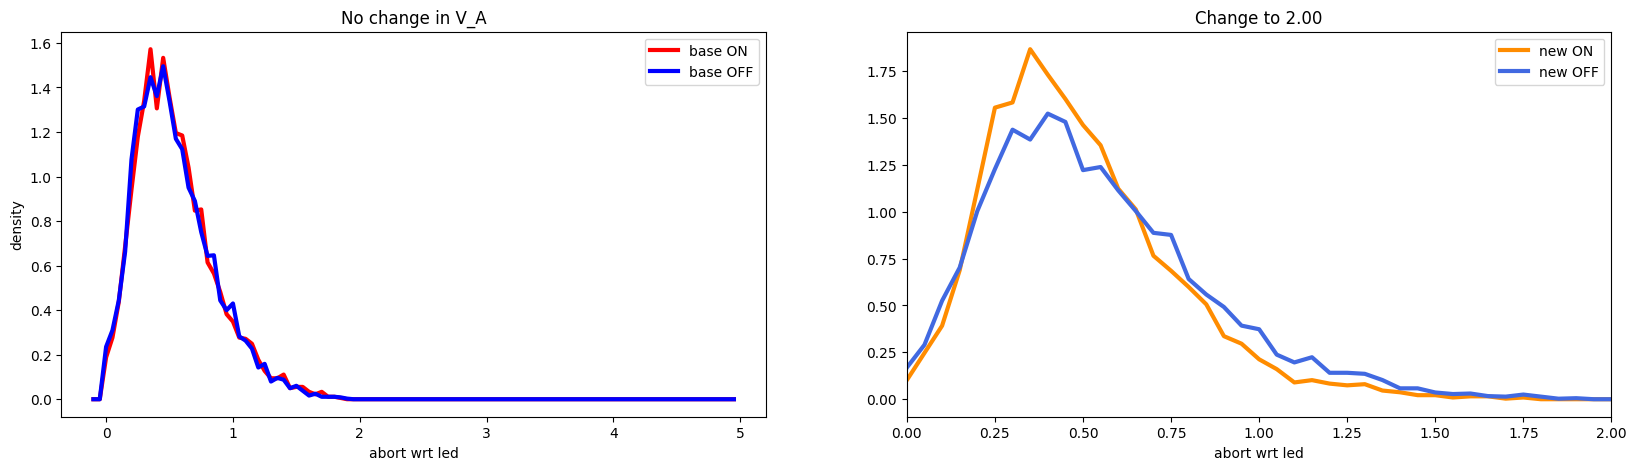

In [40]:
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.plot(t_pts, base_on_wrt_led_prob, label='base ON', color='r', lw=3)
plt.plot(t_pts, base_off_wrt_led_prob, label='base OFF', color='b', lw=3)
plt.title('No change in V_A')
plt.xlabel('abort wrt led')
plt.ylabel('density')
plt.legend()


plt.subplot(1,2,2)
plt.plot(t_pts, new_on_wrt_led_prob, label='new ON', color='darkorange', lw=3)
plt.plot(t_pts, new_off_wrt_led_prob, label='new OFF', color='royalblue', lw=3)
plt.title(f'Change to {new_V_A_value:.2f}')
plt.xlabel('abort wrt led')
plt.xlim(0,2)
plt.legend()


# psth of aborts wrt real data

In [49]:
all_led_on = df[ df['LED_trial'] == 1 ]
all_led_off = df [ df['LED_trial'] == 0 ]

bin_width = 0.1
t_min = -1; t_max = 2; n_pts = int((t_max - t_min) / bin_width)

t_bins = np.linspace(t_min, t_max, n_pts)

animal_led_off_counts = np.linspace(t_min, t_max, n_pts)
N_aborts = 0
for _, trial in all_led_off.iterrows():
    if trial['timed_fix'] < trial['intended_fix'] and trial['timed_fix'] > trial['LED_onset_time']:# if aborts
        led_onset_time = trial['LED_onset_time']
        abort_time = trial['timed_fix']

        abort_wrt_led_onset = abort_time - led_onset_time
        abort_wrt_led_onset_ms_idx = int((abort_wrt_led_onset - t_min) / bin_width)

        animal_led_off_counts[abort_wrt_led_onset_ms_idx] += 1
        N_aborts += 1


animal_led_off_counts /= (N_aborts*bin_width)
animal_led_off_counts *= N_aborts/len(all_led_off)


# on trials

animal_led_on_counts = np.linspace(t_min, t_max, n_pts)
N_aborts = 0
for _, trial in all_led_on.iterrows():
    if trial['timed_fix'] < trial['intended_fix'] and trial['timed_fix'] > trial['LED_onset_time']:# if aborts
        led_onset_time = trial['LED_onset_time']
        abort_time = trial['timed_fix']

        abort_wrt_led_onset = abort_time - led_onset_time
        abort_wrt_led_onset_ms_idx = int((abort_wrt_led_onset - t_min) / bin_width)

        animal_led_on_counts[abort_wrt_led_onset_ms_idx] += 1
        N_aborts += 1


animal_led_on_counts /= (N_aborts*bin_width)
animal_led_on_counts *= N_aborts/len(all_led_on)

# aborts wrt led onset - simpler 

In [51]:
base_V_A_data = V_A_change_results_dict[0]['results']



# change V_A
new_V_A_idx = 2
new_V_A_value = V_A_change_results_dict[new_V_A_idx]['new_V_A']
new_V_A_data = V_A_change_results_dict[new_V_A_idx]['results']

print(f'new_V_A: {new_V_A_value}')

new_V_A: 1.4000000000000001


(0.0, 0.35)

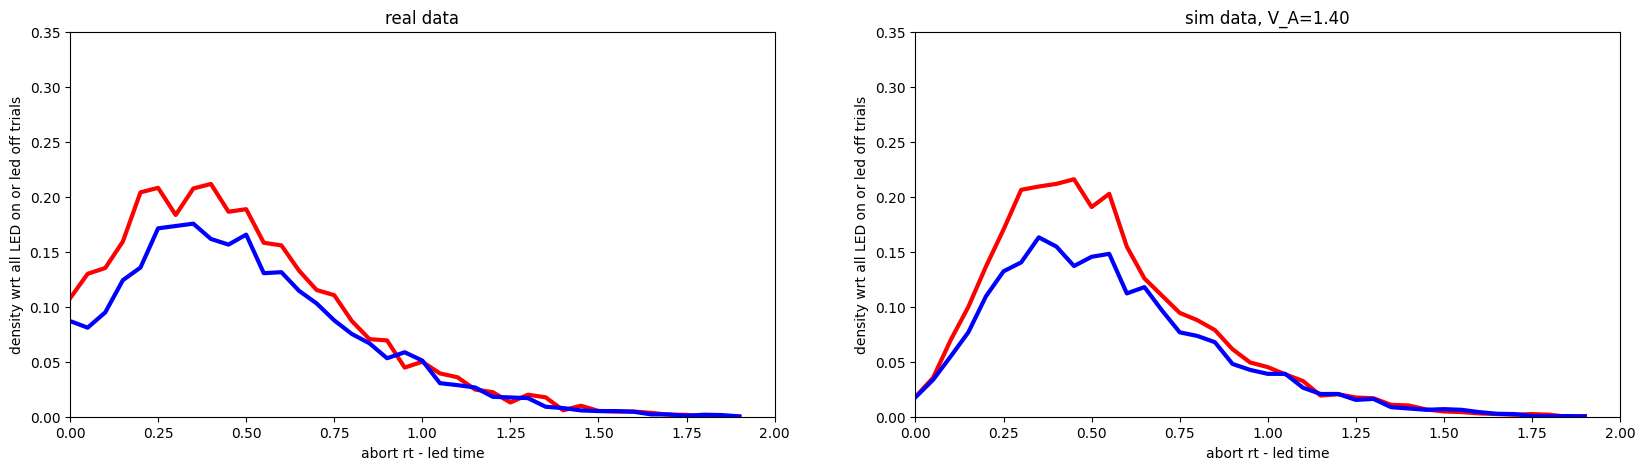

In [52]:
# real data
aborts_on_real = df [ (df['LED_trial'] == 1) & (df['timed_fix'] < df['intended_fix']) & (df['timed_fix'] > df['LED_onset_time']) ]
aborts_off_real = df [ (df['LED_trial'] == 0) & (df['timed_fix'] < df['intended_fix']) & (df['timed_fix'] > df['LED_onset_time']) ]

aborts_on_wrt_led_real = aborts_on_real['timed_fix'] - aborts_on_real['LED_onset_time']
aborts_off_wrt_led_real = aborts_off_real['timed_fix'] - aborts_off_real['LED_onset_time']

num_led_on = df[ df['LED_trial'] == 1].shape[0]
num_led_off = df[ df['LED_trial'] == 0].shape[0]

bins = np.arange(0, 2, 0.05)
aborts_on_wrt_led_hist,_ = np.histogram(aborts_on_wrt_led_real, bins=bins, density=True)
aborts_off_wrt_led_hist,_ = np.histogram(aborts_off_wrt_led_real, bins=bins, density=True)

aborts_on_wrt_led_hist *= len(aborts_on_wrt_led_real)/num_led_on
aborts_off_wrt_led_hist *= len(aborts_off_wrt_led_real)/num_led_off


# sim data
aborts_on_sim = [res['rt'] - res['t_led'] for res in new_V_A_data if res['is_LED_trial'] and res['rt'] > res['t_led'] and res['rt'] < res['t_stim']]
aborts_off_sim = [res['rt'] - res['t_led'] for res in new_V_A_data if not res['is_LED_trial'] and res['rt'] > res['t_led'] and res['rt'] < res['t_stim']]

num_led_on = len([res['is_LED_trial'] for res in new_V_A_data if res['is_LED_trial']])
num_led_off = len([res['is_LED_trial'] for res in new_V_A_data if not res['is_LED_trial']])

bins = np.arange(0, 2, 0.05)
aborts_on_wrt_led_hist_sim,_ = np.histogram(aborts_on_sim, bins=bins, density=True)
aborts_off_wrt_led_hist_sim,_ = np.histogram(aborts_off_sim, bins=bins, density=True)

aborts_on_wrt_led_hist_sim *= len(aborts_on_sim)/num_led_on
aborts_off_wrt_led_hist_sim *= len(aborts_off_sim)/num_led_off

plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.plot(bins[:-1], aborts_on_wrt_led_hist, label='LED on', color='red', lw=3)
plt.plot(bins[:-1], aborts_off_wrt_led_hist, label='LED off', color='blue', lw=3)
plt.xlim(0,2)
plt.xlabel('abort rt - led time')
plt.ylabel('density wrt all LED on or led off trials')
plt.title('real data')
plt.ylim(0, 0.35)

plt.subplot(1,2,2)
plt.plot(bins[:-1], aborts_on_wrt_led_hist_sim, label='LED on', color='red', lw=3)
plt.plot(bins[:-1], aborts_off_wrt_led_hist_sim, label='LED off', color='blue', lw=3)
plt.xlim(0,2)
plt.xlabel('abort rt - led time')
plt.ylabel('density wrt all LED on or led off trials')
plt.title(f'sim data, V_A={new_V_A_value:.2f}')
plt.ylim(0, 0.35)


In [53]:
aborts_on_sim = [res['rt'] - res['t_led'] for res in new_V_A_data if res['is_LED_trial'] and res['rt'] > res['t_led'] and res['rt'] < res['t_stim']]
aborts_off_sim = [res['rt'] - res['t_led'] for res in new_V_A_data if not res['is_LED_trial'] and res['rt'] > res['t_led'] and res['rt'] < res['t_stim']]

num_led_on_sim = len([res['is_LED_trial'] for res in new_V_A_data if res['is_LED_trial']])
num_led_off_sim = len([res['is_LED_trial'] for res in new_V_A_data if not res['is_LED_trial']])

# percentage of aborts on and aborts off
print(f'lED on aborts: {100*len(aborts_on_sim)/num_led_on_sim}')
print(f'lED off aborts: {100*len(aborts_off_sim)/num_led_off_sim}')



lED on aborts: 13.834360438899745
lED off aborts: 10.85936914662471


# Chronometric - no aborts

In [108]:
base_V_A_data = V_A_change_results_dict[0]['results']


# change V_A
new_V_A_idx = 2
new_V_A_value = V_A_change_results_dict[new_V_A_idx]['new_V_A']
new_V_A_data = V_A_change_results_dict[new_V_A_idx]['results']


In [109]:
positive_ILD_arr = ILD_arr[ILD_arr > 0]

In [110]:
# base and new init- collect rt
base_rt_abl_ild_on = {}
base_rt_abl_ild_off = {}

new_rt_abl_ild_on = {}
new_rt_abl_ild_off = {}

for ABL in ABL_arr:
    for ILD in positive_ILD_arr:
        base_rt_abl_ild_on[(ABL, ILD)] = []
        base_rt_abl_ild_off[(ABL, ILD)] = []

        new_rt_abl_ild_on[(ABL, ILD)] = []
        new_rt_abl_ild_off[(ABL, ILD)] = []

In [111]:
#  base
for res in base_V_A_data:
    ABL = res['ABL']
    ILD = res['ILD']
    abs_ILD = np.abs(ILD)

    if res['is_LED_trial']:
        if res['rt'] > res['t_led'] and res['rt'] > res['t_stim']:
            base_rt_abl_ild_on[(ABL, abs_ILD)].append(res['rt'] - res['t_stim'])
    elif not res['is_LED_trial'] and res['rt'] > res['t_stim']:
        if res['rt'] > res['t_led']:
            base_rt_abl_ild_off[(ABL, abs_ILD)].append(res['rt'] - res['t_stim'])

# new
for res in new_V_A_data:
    ABL = res['ABL']
    ILD = res['ILD']
    abs_ILD = np.abs(ILD)

    if res['is_LED_trial']:
        if res['rt'] > res['t_led'] and res['rt'] > res['t_stim']:
            new_rt_abl_ild_on[(ABL, abs_ILD)].append(res['rt'] - res['t_stim'])
    elif not res['is_LED_trial']:
        if res['rt'] > res['t_led'] and res['rt'] > res['t_stim']:
            new_rt_abl_ild_off[(ABL, abs_ILD)].append(res['rt'] - res['t_stim'])

In [112]:
# base
base_on_mean = {}
base_on_std_err = {}

base_off_mean = {}
base_off_std_err = {}

for ABL in ABL_arr:
    for ILD in positive_ILD_arr:
        base_on_mean[(ABL, ILD)] = np.mean(base_rt_abl_ild_on[(ABL, ILD)])
        base_on_std_err[(ABL, ILD)] = np.std(base_rt_abl_ild_on[(ABL, ILD)]) / np.sqrt(len(base_rt_abl_ild_on[(ABL, ILD)]))

        base_off_mean[(ABL, ILD)] = np.mean(base_rt_abl_ild_off[(ABL, ILD)])
        base_off_std_err[(ABL, ILD)] = np.std(base_rt_abl_ild_off[(ABL, ILD)]) / np.sqrt(len(base_rt_abl_ild_off[(ABL, ILD)]))


In [113]:
positive_ILD_arr = ILD_arr[ILD_arr > 0]

# new
new_on_mean = {}
new_on_std_err = {}

new_off_mean = {}
new_off_std_err = {}

for ABL in ABL_arr:
    for ILD in positive_ILD_arr:
        new_on_mean[(ABL, ILD)] = np.mean(new_rt_abl_ild_on[(ABL, ILD)])
        new_on_std_err[(ABL, ILD)] = np.std(new_rt_abl_ild_on[(ABL, ILD)]) / np.sqrt(len(new_rt_abl_ild_on[(ABL, ILD)]))

        new_off_mean[(ABL, ILD)] = np.mean(new_rt_abl_ild_off[(ABL, ILD)])
        new_off_std_err[(ABL, ILD)] = np.std(new_rt_abl_ild_off[(ABL, ILD)]) / np.sqrt(len(new_rt_abl_ild_off[(ABL, ILD)]))

In [114]:
df_1 = df [ df['LED_trial'] == 1 ]
df_0 = df [ df['LED_trial'] == 0 ]

led_on_abl_ild = {}
led_off_abl_ild = {}

positive_ILD_arr = ILD_arr[ILD_arr > 0]

for ABL in ABL_arr:
    for ILD in positive_ILD_arr:
        led_on_abl_ild[(ABL, ILD)] = []
        led_off_abl_ild[(ABL, ILD)] = []

# ON
for _, row in df_1.iterrows():
    ABL = row['ABL']
    ILD = row['ILD']
    abs_ILD = np.abs(ILD)

    if row['timed_fix'] > row['LED_onset_time'] and row['timed_fix'] > row['intended_fix']: # if after onset time
        led_on_abl_ild[(ABL, abs_ILD)].append(row['timed_fix'] - row['intended_fix'])
    
# OFF
for _, row in df_0.iterrows():
    ABL = row['ABL']
    ILD = row['ILD']
    abs_ILD = np.abs(ILD)

    if row['timed_fix'] > row['LED_onset_time'] and row['timed_fix'] > row['intended_fix']: # if after onset time
        led_off_abl_ild[(ABL, abs_ILD)].append(row['timed_fix'] - row['intended_fix'])


# on and off mean and std
led_on_mean = {}
led_on_std_err = {}

led_off_mean = {}
led_off_std_err = {}

for ABL in ABL_arr:
    for ILD in positive_ILD_arr:
        led_on_mean[(ABL, ILD)] = np.mean(led_on_abl_ild[(ABL, ILD)])
        led_on_std_err[(ABL, ILD)] = np.std(led_on_abl_ild[(ABL, ILD)])/np.sqrt(len(led_on_abl_ild[(ABL, ILD)]))

        led_off_mean[(ABL, ILD)] = np.mean(led_off_abl_ild[(ABL, ILD)])
        led_off_std_err[(ABL, ILD)] = np.std(led_off_abl_ild[(ABL, ILD)])/np.sqrt(len(led_off_abl_ild[(ABL, ILD)]))

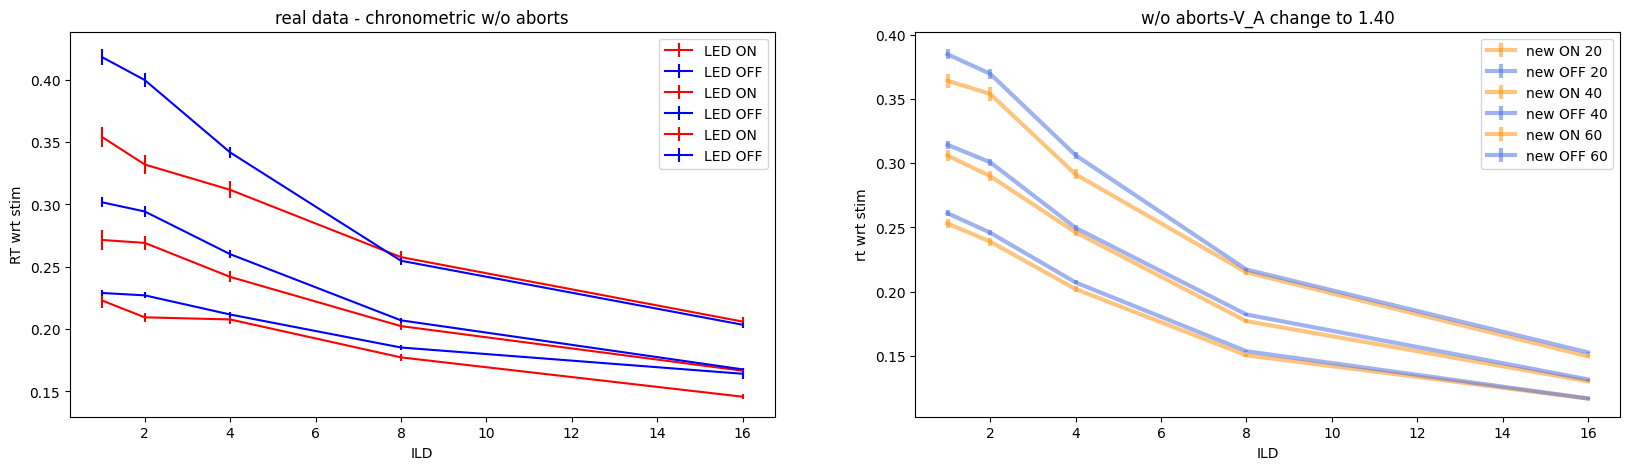

In [115]:
plt.figure(figsize=(20,5))

plt.subplot(1,2,1)
for ABL in ABL_arr:
    # mean and err vs positive ILD
    plt.errorbar(positive_ILD_arr, [led_on_mean[(ABL, ILD)] for ILD in positive_ILD_arr], yerr=[led_on_std_err[(ABL, ILD)] for ILD in positive_ILD_arr], label='LED ON', color='red')
    plt.errorbar(positive_ILD_arr, [led_off_mean[(ABL, ILD)] for ILD in positive_ILD_arr], yerr=[led_off_std_err[(ABL, ILD)] for ILD in positive_ILD_arr], label='LED OFF', color='blue')

    plt.xlabel('ILD')
    plt.ylabel('RT wrt stim')
    plt.legend()
    plt.title('real data - chronometric w/o aborts')

plt.subplot(1,2,2)
# new - mean with std err vs pos ILD
for ABL in ABL_arr:
    plt.errorbar(positive_ILD_arr, [new_on_mean[(ABL, ILD)] for ILD in positive_ILD_arr], yerr=[new_on_std_err[(ABL, ILD)] for ILD in positive_ILD_arr], label=f'new ON {ABL}', color='darkorange', lw=3, alpha=0.5)
    plt.errorbar(positive_ILD_arr, [new_off_mean[(ABL, ILD)] for ILD in positive_ILD_arr], yerr=[new_off_std_err[(ABL, ILD)] for ILD in positive_ILD_arr], label=f'new OFF {ABL}', color='royalblue', lw=3, alpha=0.5)
    plt.legend()
    plt.xlabel('ILD'); plt.ylabel('rt wrt stim')
    plt.title(f'w/o aborts-V_A change to {new_V_A_value:.2f}')

## chronometric - designed for sim data

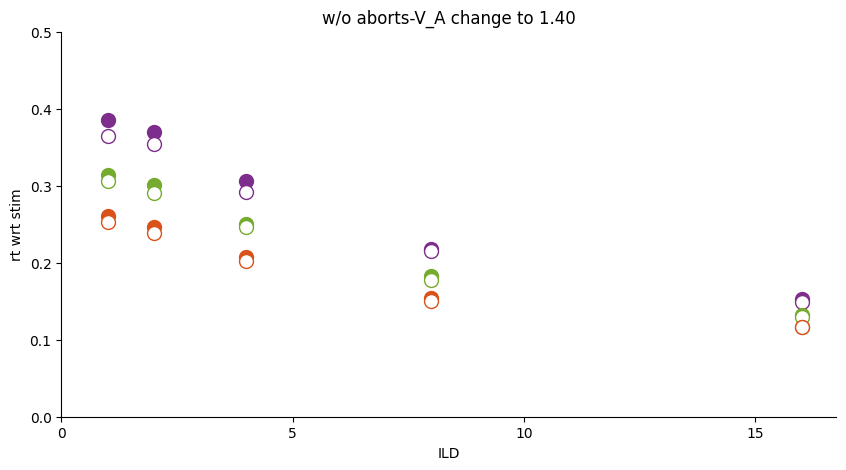

In [148]:
ABL_color_codes = {ABL_arr[0]: '#7D2E8C', ABL_arr[1]: '#75AB2E', ABL_arr[2]: '#D95219'}

plt.figure(figsize=(10,5))
for ABL in ABL_arr:
    # off filled
    # plt.errorbar(positive_ILD_arr, [new_off_mean[(ABL, ILD)] for ILD in positive_ILD_arr], yerr=[new_off_std_err[(ABL, ILD)] for ILD in positive_ILD_arr], label=f'new OFF {ABL}', color=ABL_color_codes[ABL], lw=3, alpha=0.5)
    plt.scatter(
    positive_ILD_arr, 
    [new_off_mean[(ABL, ILD)] for ILD in positive_ILD_arr], 
    label=f'new OFF {ABL}', 
    color=ABL_color_codes[ABL],  # Marker fill color
    marker='o', 
    s=100  # Adjust size as needed
)
    # plt.errorbar(
    #     positive_ILD_arr, 
    #     [new_off_mean[(ABL, ILD)] for ILD in positive_ILD_arr], 
    #     yerr=[new_off_std_err[(ABL, ILD)] for ILD in positive_ILD_arr], 
    #     fmt='none',  # No markers for error bars
    #     color=ABL_color_codes[ABL],  # Same color as the scatter markers
    #     lw=1,  # Line width for error bars
    #     capsize=3
    # )
    # ON plain
    # plt.errorbar(positive_ILD_arr, [new_on_mean[(ABL, ILD)] for ILD in positive_ILD_arr], yerr=[new_on_std_err[(ABL, ILD)] for ILD in positive_ILD_arr], label=f'new ON {ABL}', color=ABL_color_codes[ABL])
    # Scatter plot with white fill color and colored edges
    # Error bars
    # plt.errorbar(
    #     positive_ILD_arr, 
    #     [new_on_mean[(ABL, ILD)] for ILD in positive_ILD_arr], 
    #     yerr=[new_on_std_err[(ABL, ILD)] for ILD in positive_ILD_arr], 
    #     fmt='none',  # No markers for error bars
    #     color=ABL_color_codes[ABL],  # Color of the error bars (matches edge color)
    #     lw=1,
    #     capsize=3
    # )
    plt.scatter(
        positive_ILD_arr, 
        [new_on_mean[(ABL, ILD)] for ILD in positive_ILD_arr], 
        label=f'new ON {ABL}', 
        facecolor='white',  # White fill color
        edgecolor=ABL_color_codes[ABL],  # Edge color
        marker='o', 
        s=100,  # Adjust marker size as needed
        linewidths=1  # Thickness of the edge
    )

    

    # plt.legend()
    plt.xlabel('ILD'); plt.ylabel('rt wrt stim')
    plt.title(f'w/o aborts-V_A change to {new_V_A_value:.2f}')

    plt.xticks([0, 5, 10, 15])
    plt.yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5])

ax = plt.gca()  # Get the current axis
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

# grand mean of RTs , acc vs param

In [116]:
mean_vs_param_on_acc = np.zeros((N_params))
mean_vs_param_off_acc = np.zeros((N_params))


mean_vs_param_on_rt = np.zeros((N_params))
mean_vs_param_off_rt = np.zeros((N_params))



for i in range(N_params):
    results =  V_A_change_results_dict[i]['results']
    
    on_total = 0
    on_correct = 0

    off_total = 0
    off_correct = 0

    for res in results:
        if res['is_LED_trial'] and res['rt'] > res['t_led'] and res['rt'] > res['t_stim']:
            on_total += 1
            if (res['ILD'] > 0 and res['choice'] == 1) or (res['ILD'] < 0 and res['choice'] == -1):
                on_correct += 1

        elif (not res['is_LED_trial']) and res['rt'] > res['t_led'] and res['rt'] > res['t_stim']:
            off_total += 1
            if (res['ILD'] > 0 and res['choice'] == 1) or (res['ILD'] < 0 and res['choice'] == -1):
                off_correct += 1

    mean_vs_param_on_acc[i] = on_correct / on_total
    mean_vs_param_off_acc[i] = off_correct / off_total





for i in range(N_params):
    results =  V_A_change_results_dict[i]['results']

    on_rt = []
    off_rt = []

    for res in results:
        if res['is_LED_trial'] and res['rt'] > res['t_led'] and res['rt'] > res['t_stim']:
            on_rt.append(res['rt'] - res['t_stim'])
        elif (not res['is_LED_trial']) and res['rt'] > res['t_led'] and res['rt'] > res['t_stim']:
            off_rt.append(res['rt'] - res['t_stim'])

    mean_vs_param_on_rt[i] = np.mean(on_rt)
    mean_vs_param_off_rt[i] = np.mean(off_rt)



(-10.0, 1.0)

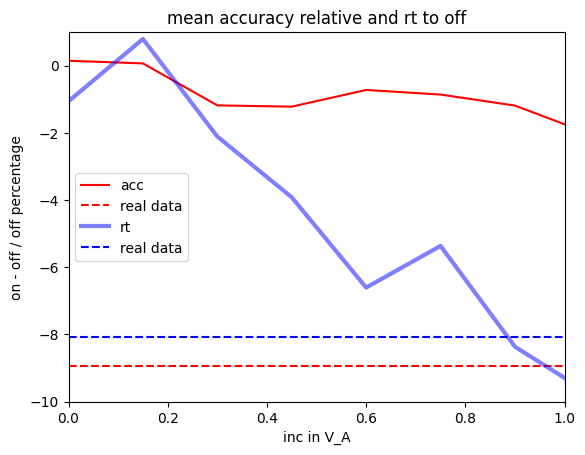

In [ ]:
plt.plot([(0 + i * step_size) for i in range(N_params)], 100*(mean_vs_param_on_acc - mean_vs_param_off_acc)/mean_vs_param_off_acc, label='acc', color='r')
plt.axhline(-8.9482, label='real data', color='r', linestyle='--')

plt.plot([(0 + i * step_size) for i in range(N_params)], 100*(mean_vs_param_on_rt - mean_vs_param_off_rt)/mean_vs_param_off_rt, label='rt', color='b', lw=3, alpha=0.5)
plt.axhline(-8.0781, label='real data', color='b', linestyle='--')

plt.legend()
plt.xlabel('inc in V_A'); plt.ylabel('on - off / off percentage')
plt.title('mean accuracy relative and rt to off');
plt.xlim(0, 1)
plt.ylim(-10, 1)


## 1M - step size = 0.1, N_sim = 11